# Introduction - Structural similarity

In previous two exercises, we have characterized chemical structures using binary vectors representing their features: either directly (structural keys such as MACCS) or in a hashed form (hashed fingerprints such as ECFP). Aside from narrowing down substructure searches or searching for specific fragments, these binary feature vectors can be used to quantify structural similarity. This is based on the premise that structures with similar feature vectors have to be structurally similar themselves. This may sound a bit sketchy, but as you will see, it works pretty well, especially with hashed fingerprints such as ECFP.

This gets us to the question of how to measure similarity of binary vectors. Luckily, this is already a pretty generic question that has been extensively worked upon long before cheminformatics was a thing. Probably the simplest, and definitely the most often used one in cheminformatics is the [Tanimoto similarity](https://en.wikipedia.org/wiki/Jaccard_index) aka the Jaccard index. Tanimoto similarity coefficient is measure of how many features do the two compared feature vectors have in common, compared to how many features they have overall. This means that feature vectors that share all features, i.e. are completely identical, will have Tanimoto coefficient 1. Feature vectors that share no features at all have Tanimoto coefficient of 0, and any other cases will be somewhere between these two limit values. Much more info is on the wiki artice, no point in copypasting :) Other measures such as [Manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry) or [Dice coefficient](https://en.wikipedia.org/wiki/Dice%27s_coefficient) are also often implemented in cheminformatic toolkits, ready to be used for some edge cases. Quite a few are described in the [Daylight documentation](https://www.daylight.com/dayhtml/doc/theory/theory.finger.html), Section 6.3. However, Tanimoto is pretty much the vanilla of binary vector comparisons. Let's implement it: 

# Goals of the exercise

 - Familiarize yourself with similarity between feature vectors (mainly Tanimoto), though you probably know it already :)
 - Implement for yourself a function that measures Tanimoto similarity between two binary vectors, and try it out.
 - Do a similarity search of your ligands within the DrugBank database using using hashed fingerprints (ECFP). Are any of your ligands significantly structurally similar to any DrugBank compounds? How many?
 - Do you think that some substances similar to your known ligands were already considered or even applied for therapeutic purposes?
 - Implement for yourself a function that measures Tanimoto dissimilarity for the purposes of diversity picking.
 - Perform diversity picking on your ligand set, i.e. use the diversity picker to select a small representative subset of mutually dissimilar structures that cover as much of the chemical diversity of your ligand set as possible. Pick at least 20 representative structures, or around 1% of your ligand set size, whichever one is greater. Visualize the picked structures.
 - Does each next picked structure differ considerably from the previously picked ones, or is the subset limited to only few structural motifs? What would the latter mean?

In [1]:
# importing necessary modules
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import csv

RDKit WARNING: [17:36:12] Enabling RDKit 2019.09.3 jupyter extensions


## Implementing Tanimoto similarity function

In [2]:
# let's define the Tanimoto similarity for ourselves:

def tanimoto(vector1, vector2):
    set_bits = 0
    shared_bits = 0
    for bit1, bit2 in zip(vector1, vector2):
        if bit1 or bit2: # at least one vector has this feature
            set_bits += 1
            if bit1 and bit2: # both vectors have this feature
                shared_bits += 1
    return shared_bits / set_bits

# I really tried to implement it myself
def tanimoto_2(v1,v2):
    a,b = 0,0
    for i,v in enumerate(v1):
        if v == v2[i]:
            a+=1
        else:
            b+=1
    return a/(a+b)
   
       
# and check our implementation on several vectors
print(tanimoto([1, 1, 0, 0], [0, 0, 1, 1])) # share nothing
print(tanimoto([0, 1, 1, 0], [1, 0, 1, 0])) # share bit of 3 # share of two bits?
print(tanimoto([1, 1, 1, 1], [0, 0, 1, 1])) # share 2 bits of 4
print(tanimoto([1, 1, 1, 1], [0, 1, 1, 1])) # share 3 bits of 4
print(tanimoto([1, 1, 0, 0], [1, 1, 0, 0])) # share 2 bits of 2 # 4 of 4?
print()
print(tanimoto_2([1, 1, 0, 0], [0, 0, 1, 1])) # share nothing
print(tanimoto_2([0, 1, 1, 0], [1, 0, 1, 0])) # share bit of 3  # share of two bits?
print(tanimoto_2([1, 1, 1, 1], [0, 0, 1, 1])) # share 2 bits of 4
print(tanimoto_2([1, 1, 1, 1], [0, 1, 1, 1])) # share 3 bits of 4
print(tanimoto_2([1, 1, 0, 0], [1, 1, 0, 0])) # share 2 bits of 2 # 4 of 4?

0.0
0.3333333333333333
0.5
0.75
1.0

0.0
0.5
0.5
0.75
1.0


This implementation seems ok for our little 4-bit vectors. Let's try it on some actual fingerprint vectors :)

In [3]:
# loading the data
with open('Cytochrome_P450_targets.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    cytc_ligands = [Chem.MolFromSmiles(m['Smiles']) for m in reader]

suppl = Chem.SDMolSupplier('../data/drugbank.sdf')
drugs = [m for m in suppl if m]

RDKit ERROR: [17:36:17] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [17:36:17] ERROR: Could not sanitize molecule ending on line 20009
RDKit WARNING: [17:36:17] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit WARNING: [17:36:17] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit ERROR: [17:36:17] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [17:36:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [17:36:17] ERROR: Could not sanitize molecule ending on line 250947
RDKit ERROR: [17:36:17] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [17:36:17] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [17:36:17] ERROR: Could not sanitize molecule ending on line 258130
RDKit ERROR: [17:36:17] ERROR: Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [17:36:17] Can't kek

In [4]:
from rdkit.Chem import MACCSkeys
fp1 = MACCSkeys.GenMACCSKeys(drugs[123])
fp2 = MACCSkeys.GenMACCSKeys(drugs[666])
print(fp1.ToBitString())
print(fp2.ToBitString())

00000000000000000000000000000000000000000000000000000100000000000000000000000000000010000100000001000000000000000100000000010001000101010001000110100011101011110111110
00000000000000000000000000000010000000000000000001000000010000000000000000100000000001100000010100101100010011011101101000110110000010000110010011111100111111111111110


In [5]:
print(tanimoto(fp1, fp2))
print(tanimoto_2(fp1, fp2))

0.25
0.7305389221556886


At this step, I realized that I didn't implement tanimoto function in a right way :( But at least I tried.

So, our ghetto tanimoto similarity implementation work on the MACCS keys too. Luckily, we do not have to implement similarity metrics ourselves - many are [already implemented in RDKit](https://www.rdkit.org/docs/source/rdkit.DataStructs.cDataStructs.html): 

In [6]:
from rdkit import DataStructs

In [7]:
DataStructs.TanimotoSimilarity(fp1, fp2) # same result as our own implementation :) but not mine! :(

0.25

## Performing similarity search of your ligands within the DrugBank database using hashed fingerprints (ECFP)

Now that we have our Tanimoto similarity tried and tested for both artificial small vector and also on some actual fingerprints, let's calculate MACCS keys for all our ligands and all our known drugs. Then, we can try a basic similarity search:

In [8]:
cytc_ligands_maccs = [MACCSkeys.GenMACCSKeys(m) for m in cytc_ligands]
drugs_maccs = [MACCSkeys.GenMACCSKeys(m) for m in drugs]

Let's implement a basic similarity search function. We will take a single binary vector as a query, compare it all binary vectors in the provided searched set. If its the Tanimoto similarity of the query vector to any of the searched fingerprints reaches or exceed our set cutoff value (0.8 is usually where some noticeable similarity starts to happen when using standard ECFP types), the index of the found similar vector is appended to the results.

In [9]:
def similarity_search(query_fp, searched_fp_set, cutoff=0.8):
    # we have no index, so we will have to just iterate through the entire searched set
    hits = []
    for i, fp in enumerate(searched_fp_set):
        similarity = DataStructs.TanimotoSimilarity(query_fp, fp)
        if similarity >= cutoff: # similar enough for consideration
            hits.append((i, similarity))
    return sorted(hits, key=lambda x: x[1], reverse=True) # stronger hits first

This is, in a very simplified fashon, exactly what the large, often commercial chemical databases do when users perform a similarity search. Their input structure gets fingerprinted, the resulting fingerprint compared to those in the database, and molecules with similar fingerprints are returned as hits. Of course, they do extended indexing and heuristics to make the searches quicker, alongside some hit reordering and sanitation, but the core principle is the same: create query fingerprint, compare with database fingerprints using some similarity metric, return hits above threshold. Same sh.t, different toilet :)

In this case, I randomly selected ligand 15 for the analysis but later in I will perform the search to find more molecules which are simillar to drugbank.

In [10]:
hits = similarity_search(cytc_ligands_maccs[15], drugs_maccs)
hits

[(4540, 1.0),
 (259, 0.9230769230769231),
 (4603, 0.9230769230769231),
 (7002, 0.9),
 (1052, 0.8611111111111112),
 (603, 0.8292682926829268)]

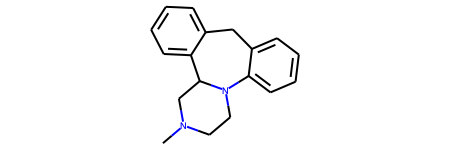

In [11]:
cytc_ligands[15]  # my query structure

As it is seeen we found a perfect match for this ligand and another 5 molecules which matched over 80 %.

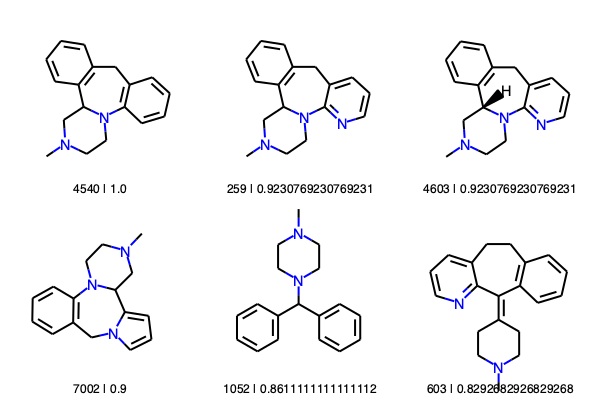

In [12]:
# the hits among Drugbank using MACCS keys
Draw.MolsToGridImage([drugs[hit[0]] for hit in hits], legends=["{} | {}".format(hit[0], hit[1]) for hit in hits])

As we can see cytochrome P450 ligand can be also found in drugbank ligands with structural similarity 1.0 as well as other structures with similarity over 0.8.

Let's do the same exact query, but using Extended Connectivity Fingerprint instead of MACCS:

In [13]:
cytc_ligands_ecfp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)
                     for m in cytc_ligands]
drugs_ecfp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)
              for m in drugs]

In [14]:
hits = similarity_search(cytc_ligands_ecfp[15], drugs_ecfp)
hits

[(4540, 1.0)]

As we can see we found a perfect natch with Extended Connectivity Fingerprint search however other simillar structures were not found. Let's see what the ECFP-based similarity with the two previous MACCS-based hits is:

In [15]:
DataStructs.TanimotoSimilarity(cytc_ligands_ecfp[15], drugs_ecfp[259])

0.6428571428571429

In [16]:
DataStructs.TanimotoSimilarity(cytc_ligands_ecfp[15], drugs_ecfp[4603])

0.6428571428571429

In [17]:
DataStructs.TanimotoSimilarity(cytc_ligands_ecfp[15], drugs_ecfp[7002])

0.5581395348837209

In [18]:
DataStructs.TanimotoSimilarity(cytc_ligands_ecfp[15], drugs_ecfp[1052])

0.30952380952380953

In [19]:
DataStructs.TanimotoSimilarity(cytc_ligands_ecfp[15], drugs_ecfp[603])

0.2692307692307692

As we can see the similarity measurment was different in MACCS compare to ECFP, the reason foe that was explained in tutorial.

Same query molecule, same similarity measurement, but a different feature vector type yielded very different results. The two structures hit by the similarity search based on the MACCS keys (over 0.8 Tanimoto similarity) have much lower similarity values when using ECFP. This is because MACCS and ECFP are quite different in what structural features they cover. When using fingerprint-based similarity search, it is always good idea to think a bit about what structural features do the used fingerprints represent, and therefore what is used as the basis for structural similarity. It is also a good idea to include information about the exact used feature vector type (e.g. MACCS, ECFP6-1024 bit, ECFP4-512 bit, etc.) and the exact used similarity measurement method (e.g. Tanimoto, Manhattan) whenever you present any similarity search results.

Let's search for all our ligands among the DrugBank database, to see how close we are to the known drugs:

In [20]:
cytc_ligands_queries = [(i, similarity_search(ligand_ecfp, drugs_ecfp))
                     for i, ligand_ecfp in enumerate(cytc_ligands_ecfp)]
cytc_ligands_queries

[(0, []),
 (1, []),
 (2, []),
 (3, []),
 (4, []),
 (5, []),
 (6, []),
 (7, []),
 (8, []),
 (9, []),
 (10, []),
 (11, []),
 (12, [(945, 1.0)]),
 (13, []),
 (14, [(1012, 1.0)]),
 (15, [(4540, 1.0)]),
 (16, []),
 (17, []),
 (18, []),
 (19, []),
 (20, []),
 (21, []),
 (22, []),
 (23, []),
 (24, []),
 (25, []),
 (26, [(719, 1.0)]),
 (27, []),
 (28, []),
 (29, []),
 (30, []),
 (31, []),
 (32, []),
 (33, []),
 (34, []),
 (35, []),
 (36, []),
 (37, []),
 (38, []),
 (39, []),
 (40, []),
 (41, []),
 (42, []),
 (43, []),
 (44, []),
 (45, []),
 (46, []),
 (47, []),
 (48, []),
 (49, []),
 (50, []),
 (51, [(486, 1.0)]),
 (52, []),
 (53, []),
 (54, []),
 (55, []),
 (56, []),
 (57, []),
 (58, []),
 (59, []),
 (60, []),
 (61, []),
 (62, []),
 (63, []),
 (64, []),
 (65, []),
 (66, []),
 (67, [(4641, 1.0)]),
 (68, []),
 (69, []),
 (70, []),
 (71, []),
 (72, []),
 (73, []),
 (74, []),
 (75, []),
 (76, []),
 (77, []),
 (78, []),
 (79, []),
 (80, []),
 (81, []),
 (82, [(137, 1.0)]),
 (83, []),
 (84, []),
 (

For every ligand, we have a list of drugs that match their structural features (ECFP4, 1024bit) at Tanimoto similarity of 0.8 and higher. Most queries come up empty at this similarity threshold of 0.8, but there are some actual hits:

In [21]:
# only take ligands that actually matched something in DrugBank
cytc_ligand_hits = [hit for hit in cytc_ligands_queries if hit[1]]
cytc_ligand_hits

[(12, [(945, 1.0)]),
 (14, [(1012, 1.0)]),
 (15, [(4540, 1.0)]),
 (26, [(719, 1.0)]),
 (51, [(486, 1.0)]),
 (67, [(4641, 1.0)]),
 (82, [(137, 1.0)]),
 (91, [(1073, 1.0), (1775, 1.0)]),
 (98, [(106, 1.0), (1051, 1.0)]),
 (100, [(4641, 1.0)]),
 (107, [(115, 1.0)]),
 (108, [(1027, 1.0)]),
 (173, [(534, 1.0)]),
 (178, [(1603, 1.0), (1889, 1.0), (3871, 1.0)]),
 (191, [(1370, 1.0)]),
 (195, [(455, 1.0), (426, 0.89), (199, 0.8431372549019608)]),
 (200, [(467, 1.0)]),
 (212, [(4418, 1.0)]),
 (231, [(6666, 0.8181818181818182)]),
 (269, [(1156, 1.0)]),
 (271, [(245, 1.0)]),
 (272, [(902, 1.0)]),
 (273,
  [(579, 1.0),
   (332, 0.8767123287671232),
   (876, 0.8767123287671232),
   (1053, 0.8285714285714286)]),
 (290, [(1212, 1.0), (396, 0.84), (278, 0.8055555555555556)]),
 (291, [(508, 1.0), (714, 0.8163265306122449)]),
 (293, [(566, 1.0)]),
 (302, [(808, 1.0)]),
 (320, [(741, 1.0)]),
 (321, [(232, 1.0)]),
 (322, [(128, 1.0)]),
 (326, [(254, 1.0)]),
 (329, [(801, 1.0)]),
 (331, [(3413, 1.0)]),
 (3

In [22]:
len(cytc_ligands_queries), len(cytc_ligand_hits)

(5841, 842)

Here, 842 of 5841 ligands appear to be significantly structurally similar to something in DrugBank. Let's have a look at one of the ligand hits:

In [23]:
cytc_ligand_hits[1]

(14, [(1012, 1.0)])

In the above, the cytochrome P450 ligand 14 hits DrugBank structure 1012 fully by Tanimoto similarity over ECFP4 fingerprints. To visualize the structures: 

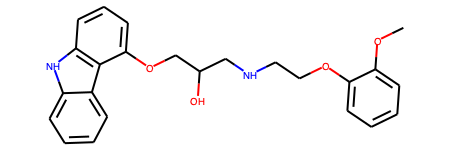

In [24]:
# The query structure
cytc_ligands[cytc_ligand_hits[1][0]]

Let's see what it hits:

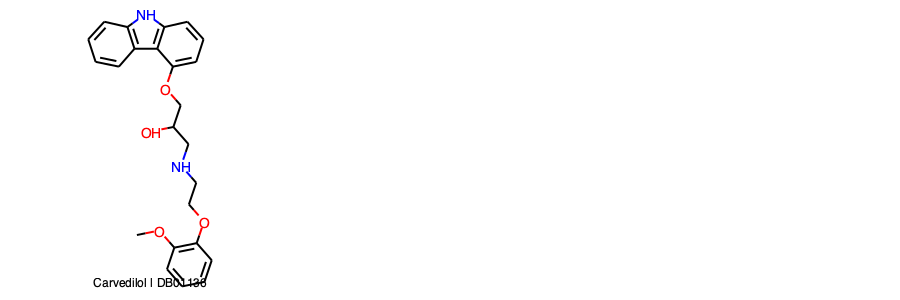

In [25]:
# And the DrugBank hits to that
hit_mols = [drugs[index] for index, similarity in cytc_ligand_hits[1][1]]
Draw.MolsToGridImage(hit_mols, molsPerRow=3, subImgSize=(300,300),
                     legends=["{} | {}".format(m.GetProp('GENERIC_NAME'), m.GetProp('DRUGBANK_ID'))
                              for m in hit_mols])

Yeah, the hits in DrugBank are also very simillar structure, the only difference I found so far is a single bond in pyrrolidin between two benzen (whole structure is actually carbazide however I hope the explanation is clear). 

True
i = 5
# hits =  2


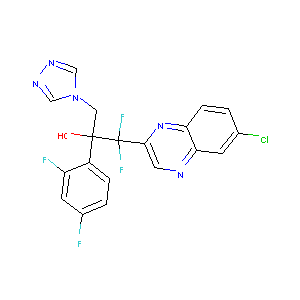

True
i = 12
# hits =  3


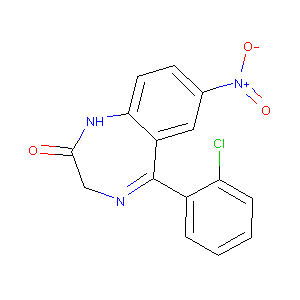

True
i = 15
# hits =  6


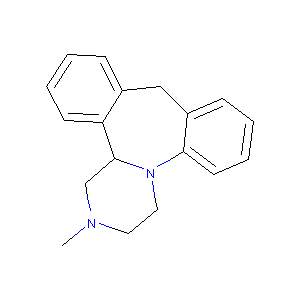

True
i = 67
# hits =  12


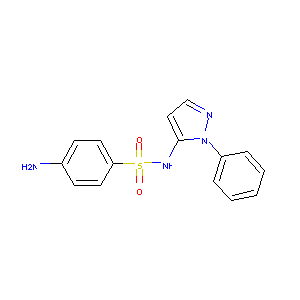

True
i = 173
# hits =  22


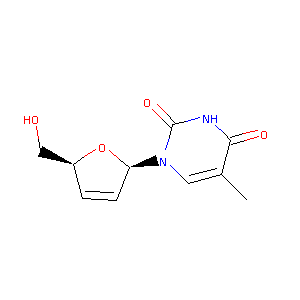

True
i = 333
# hits =  23


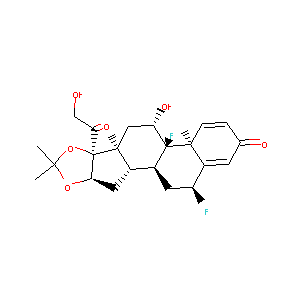

True
i = 344
# hits =  32


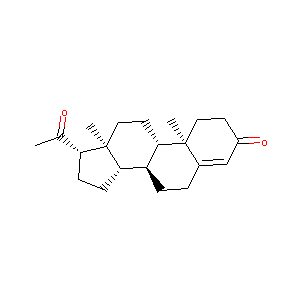

True
i = 965
# hits =  47


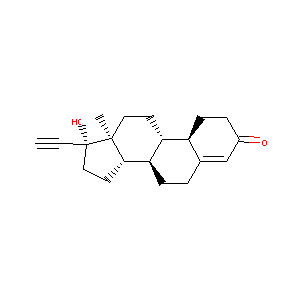

True
i = 1213
# hits =  57


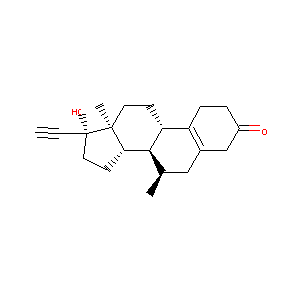

True
i = 1494
# hits =  60


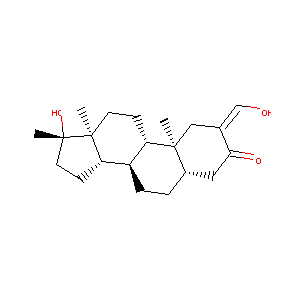

True
i = 2884
# hits =  66


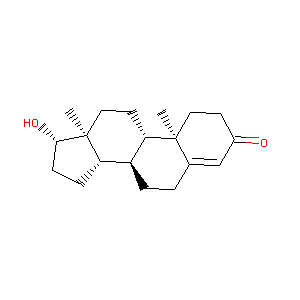

In [26]:
# finding which molecule from the set is simillar to other compounds in drugbank
length = 0
for i in range(len(cytc_ligands_maccs)):
    hits = similarity_search(cytc_ligands_maccs[i], drugs_maccs)
    if(length<len(hits)):
        length=len(hits)
        # kontrola, jestli sedi pozicne, ale mely by
        print(MACCSkeys.GenMACCSKeys(cytc_ligands[i]) == cytc_ligands_maccs[i])
        print('i =',i)
        print('# hits = ',len(hits))
        display(Chem.Draw.MolToImage(cytc_ligands[i]))

We can see from above that ligands 1494 and 2884 have over 60 hits. 

# Diversity picking

Finding molecules that are structurally similar to our query is very useful, and indeed very often used, but it is not the only way to practically utilize the concept of structural similarity. Sometimes, the problem is very different. Often, there is a scenario where we have a large set of candidate structures, and limited time/resources/money/facilities to model/prepare/buy/test them. A computationally expensive model that can realistically process only a fraction of all your virtual compounds. A limited budget to buy substances. A grumpy and already overworked synthetic chemist. You get the idea :)

In those cases, you want to prioritize those structures of your set that have the potential to be most useful. This is usually done by using faster, less resource-intensive computational approaches. However, other things being equal, you also want to preserve the chemical diversity in your set of candidate structures. Testing 1000th variant of the same basic structure can be a waste of time in early stages of screening, chemists will do plenty of that in later stages of lead development, for the very best candidates.

In screening, it is often advantageous to sample a large set of structures in a way that covers as much of the set's chemical diversity in as few chemical structures as possible. Structural diversity is often defined an inverse of their structural similarity. Let's implement such an inverse of Tanimoto similarity, a "structural distance" of sorts:

In [77]:
def distance_function(index1, index2, *args, fingerprints=cytc_ligands_ecfp,
                      metric=DataStructs.TanimotoSimilarity):
    return 1 - DataStructs.FingerprintSimilarity(fingerprints[index1],
                                                 fingerprints[index2],
                                                 metric=metric)

Using this distance function, we can pick structures from our set so that we pick the first structure at random, the second structure as the one most distant from the first, the third structure would be the one most distant from the previous two, the fourth one the most distant from the previous three, etc. etc., until we have our diverse representative subset of chosen size. However, this distance recomputing can be quite expensive, especially for larger substance set. For few thousand structures maybe, but try a billion and despair. There are however some implementations that employ heuristics to make this selection process much faster. They are not guaranteed to provide absolutely optimal coverage, but their near-optimal solutions are perfectly fine in practice and much faster to compute. RDKit implements such pickers, most notably the MaxMin picker [described nicely here](https://rdkit.blogspot.com/2017/11/revisting-maxminpicker.html). Let's use it on our ligand set, and grab about 1%-sized diverse subset based on distance between their ECFP vectors:

In [78]:
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
picker = MaxMinPicker()
picked = list(picker.LazyPick(distance_function, len(cytc_ligands), 45))
picked

[2116,
 84,
 459,
 3044,
 5290,
 3012,
 5494,
 970,
 4870,
 2809,
 4828,
 3014,
 4542,
 4775,
 452,
 2023,
 4615,
 4362,
 4477,
 4458,
 4386,
 4471,
 1946,
 387,
 3145,
 39,
 3938,
 2570,
 1173,
 2776,
 2342,
 3501,
 5492,
 5376,
 439,
 3358,
 4089,
 746,
 1871,
 3929,
 4897,
 5793,
 1411,
 1608,
 956]

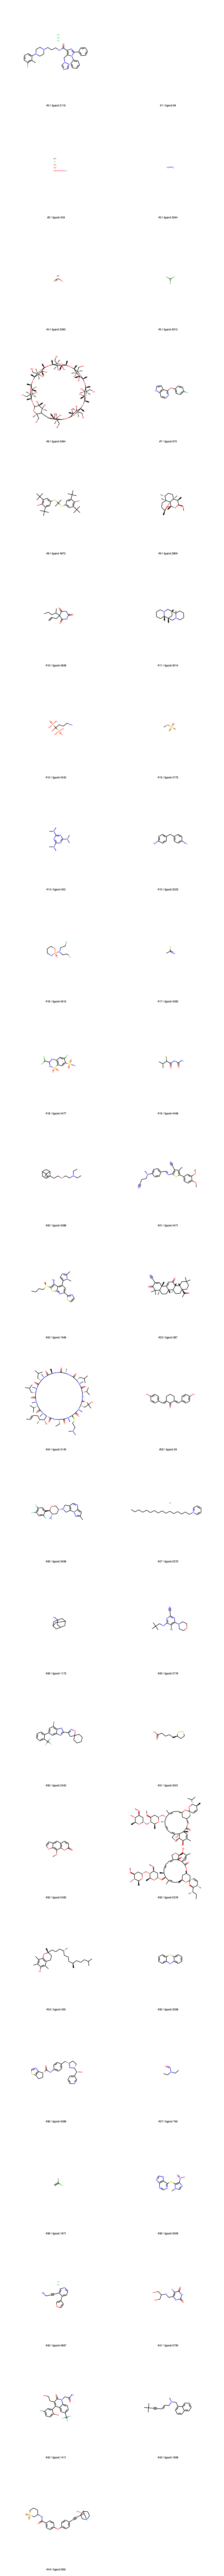

In [79]:
Draw.MolsToGridImage([cytc_ligands[i] for i in picked], molsPerRow=2, subImgSize=(500,500),
                     legends=["#{} | ligand {}".format(i, hit) for i, hit in enumerate(picked)])

That looks quite diverse :)

## Conclusion

* In this exercise I checked structural simollarity of my dataset with drugbank
* I learned that for calculation of structural similarity I can use Tanimoto or Jaccard index
* I also searched for diverse structures in my dataset